# Agent Development Kit による AI エージェントの構築と実行

このノートブックでは、Google Cloud Vertex AI と Agent Development Kit (ADK) を使用して、AI エージェントを構築・実行する一連の流れを解説します。

主なステップは以下の通りです。

1. **環境の準備**:
* 必要な Google Cloud API の有効化およびライブラリ（`google-adk`, `google-genai`, `google-cloud-aiplatform`）のインストールを行います。


2. **Search Agent の作成**:
* `Google Search` ツールを装備し、日本語で回答するよう指示（System Instruction）を与えた `LlmAgent` を定義します。
* 定義したエージェントを `AdkApp` として初期化します。


3. **実行と動作確認**:
* `ChatClient` を用いて、ノートブック上でエージェントに対話的なクエリ（例：「高田馬場のおすすめのカレー屋」）を投げ、回答を生成させます。
* 回答の生成に使用された検索クエリや参照元（Grounding）を確認します。


4. **内部動作の解析**:
* セッション情報や会話履歴（イベント）のデータ構造を確認します。
* デバッグ用の手法を用いて、実際に LLM (Gemini) に送信されている生のプロンプトやシステム指示の内容を覗き見ます。


5. **デプロイとクリーンアップ**:
* Agent Engine へのデプロイおよび作成したリソースの削除手順について説明します。

## 事前準備

1. Google Cloud の新しいプロジェクトを作成します。
2. Cloud Shell を開いて、次のコマンドで API を有効化します。
```
gcloud services enable \
  aiplatform.googleapis.com \
  notebooks.googleapis.com \
  cloudresourcemanager.googleapis.com

```
3. 次のコマンドで Vertex AI Workbench のインスタンスを作成します。
```
PROJECT_ID=$(gcloud config list --format 'value(core.project)')
gcloud workbench instances create agent-development \
  --project=$PROJECT_ID \
  --location=us-central1-a \
  --machine-type=e2-standard-2
```

4. クラウドコンソールのナビゲーションメニューから「Vertex AI」→「Workbench」を選択すると、作成したインスタンス agent-develpment があります。インスタンスの起動が完了するのを待って、「JUPYTERLAB を開く」をクリックしたら、「Python 3(ipykernel)」の新規ノートブックを作成します。

5. この後は、ノートブック上で以下のコマンドを実行していきます。

## ADK パッケージのインストール

In [ ]:
%pip install --upgrade --user \
    google-adk==1.21.0 \
    google-genai==1.56.0 \
    google-cloud-aiplatform==1.132.0

In [2]:
!pip list | grep -E "(google-adk|google-genai|google-cloud-aiplatform)"

google-adk                               1.21.0
google-cloud-aiplatform                  1.132.0
google-genai                             1.56.0


インストールしたパッケージを利用可能にするために、次のコマンドでカーネルを再起動します。

再起動を確認するポップアップが表示されるので [Ok] をクリックします。

In [2]:
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

## Search Agent App の作成

In [1]:
import copy
import datetime
import json
import os

from IPython.display import HTML, Markdown, display
import vertexai
from google.adk.agents.llm_agent import LlmAgent
from google.adk.tools import google_search
from google.genai.types import Content, Part
from vertexai.agent_engines import AdkApp

[PROJECT_ID] = !gcloud config list --format 'value(core.project)' 2>/dev/null
LOCATION = 'us-central1'

vertexai.init(
    project=PROJECT_ID, location=LOCATION,
)

os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT_ID
os.environ['GOOGLE_CLOUD_LOCATION'] = LOCATION
os.environ['GOOGLE_GENAI_USE_VERTEXAI'] = 'True'

In [2]:
instruction = '''
You are a friendly AI assistant that answers user's queries.
Use google_search to give answers based on the latest and objective information.

[Format instruction]
Output in Japanese.
Avoid adding citation marks such as [1][2].
'''

search_agent = LlmAgent(
    name='search_agent',
    model='gemini-2.5-flash',
    description='Agent to answer questions using Google Search.',
    instruction=instruction,
    tools=[google_search],
)

search_agent_app = AdkApp(
    agent=search_agent,
    app_name='search_agent_app',
)

In [3]:
# Chat client to test AdkApp
class ChatClient:
    def __init__(self, adk_app, user_id='default_user'):
        self.adk_app = adk_app
        self.user_id = user_id
        self.session_id = None

    async def async_stream_query(self, message):
        if not self.session_id:
            session = await self.adk_app.async_create_session(
                user_id=self.user_id,
            )
            self.session_id = getattr(session, 'id', None) or session['id']

        result = []
        async for event in self.adk_app.async_stream_query(
            user_id=self.user_id,
            session_id=self.session_id,
            message=message,
        ):
            if ('content' in event and 'parts' in event['content']):
                response = '\n'.join(
                    [p['text'] for p in event['content']['parts'] if 'text' in p]
                )
                if response:
                    result.append(response)
        return '\n'.join(result)

## 実行例

In [4]:
chat_client = ChatClient(search_agent_app)

query = '''
高田馬場のおすすめのカレー屋は？
'''
response = await chat_client.async_stream_query(query)
display(Markdown(response))

高田馬場には美味しいカレー屋さんが数多くあります。特におすすめのお店をいくつかご紹介します。

*   **カレーライス専門店 ブラザー**: 高田馬場でも特に人気の高いお店で、鯖キーマカレーや野菜カレーが有名です。行列ができることもありますが、提供が早いことでも知られています。辛さの調整も可能です。
*   **エチオピア 高田馬場店**: 神保町に本店を構える有名店で、スパイスが効いた薬膳的な爽やかさが特徴のインド風カリーを提供しています。0から70段階で辛さを選ぶことができ、ゴロゴロとした大きな野菜や肉が入っています。欧風カレーやドライカレーも人気です。
*   **横浜ボンベイ 高田馬場店**: サラッとしたルーが特徴で、特に「カシミールカレー」は長年愛される超有名メニューです。極辛口ながらも野菜の甘みと20種類以上の厳選スパイスが絶妙なバランスを生み出しています。上野デリーの流れを汲むお店としても知られています。
*   **プネウマカレー**: コスパが良いと評判の人気店で、30秒で提供される「無水カレー」が特徴です。
*   **アプサラ**: 人気のスリランカカレーが楽しめるお店です。
*   **Nong Inlay（ノング インレイ）**: ミャンマーの少数民族シャン族の料理を提供するお店で、酸味と辛味が効いた「短頭鯰（ナマズ）カレー」など、本格的なアジアンカレーを味わえます。高田馬場駅から徒歩約1分とアクセスも良好です。
*   **まっちゃんカレー**: ロックな雰囲気のキーマカレーが楽しめるお店です。
*   **1/f ゆらぎ（エフブンノイチゆらぎ）**: シチューのように濃厚な「白カレー」が特徴です。

これらの店舗は、それぞれ異なる種類のカレーを提供しており、お好みに合わせて選ぶことができます。

SessionService が管理するセッション情報を確認します。

セッションを特定するのに必要な、`user_id`、`session_id` を確認します。

In [5]:
user_id = chat_client.user_id
session_id = chat_client.session_id

user_id, session_id

('default_user', '412789d7-1296-4825-a03e-ff5310ab15bb')

確認した情報を使って、セッションに保存された情報を確認します。

2 つのイベント（ユーザーの質問とエージェントの回答）が記録されています。

エージェントの回答を生成する際に用いた Google Serch の情報なども確認できます。

In [6]:
session = await chat_client.adk_app.async_get_session(
    user_id = user_id,
    session_id = session_id,
)

session

Session(id='412789d7-1296-4825-a03e-ff5310ab15bb', app_name='search_agent_app', user_id='default_user', state={}, events=[Event(model_version=None, content=Content(
  parts=[
    Part(
      text="""
高田馬場のおすすめのカレー屋は？
"""
    ),
  ],
  role='user'
), grounding_metadata=None, partial=None, turn_complete=None, finish_reason=None, error_code=None, error_message=None, interrupted=None, custom_metadata=None, usage_metadata=None, live_session_resumption_update=None, input_transcription=None, output_transcription=None, avg_logprobs=None, logprobs_result=None, cache_metadata=None, citation_metadata=None, interaction_id=None, invocation_id='e-3770b51f-9a24-45bc-9fef-1adc32c30cf9', author='user', actions=EventActions(skip_summarization=None, state_delta={}, artifact_delta={}, transfer_to_agent=None, escalate=None, requested_auth_configs={}, requested_tool_confirmations={}, compaction=None, end_of_agent=None, agent_state=None, rewind_before_invocation_id=None), long_running_tool_ids=None, branch=N

Agent Engine にデプロイした際との互換性のために Session オブジェクトを Python dict に変換します。

In [7]:
def session_do_dict(session):
    
    def to_camel_case(snake_str):
        components = snake_str.split('_')
        return components[0] + ''.join(x.capitalize() for x in components[1:])

    def camel_case_keys(d):
        return {to_camel_case(k): v for k, v in d.items()}

    return json.loads(session.model_dump_json(), object_hook=camel_case_keys)

session_dict = session_do_dict(session)

次のように、これまでのやり取りが「イベント」として記録されています。

In [8]:
def format_timestamp(ts):
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S.%f')

for event in session_dict['events']:
    print(format_timestamp(event['timestamp']), event['author'])

2026-01-22 04:47:30.608365 user
2026-01-22 04:47:30.612387 search_agent


特に、下記の要素から Google 検索に使ったキーワードが確認できます。

In [9]:
search_queries = session_dict['events'][1]['groundingMetadata']['webSearchQueries']
entry_point_html = session_dict['events'][1]['groundingMetadata']['searchEntryPoint']['renderedContent']

print(search_queries)
display(HTML(entry_point_html))

['高田馬場 カレー おすすめ', '高田馬場 スパイスカレー おすすめ', '高田馬場 人気 カレー', '高田馬場 食べログ カレー ランキング']


続けて質問すると、セッション情報を踏まえた回答が得られます。

In [10]:
query = '''
特に家族連れにおすすめなのは？
'''
response = await chat_client.async_stream_query(query)
display(Markdown(response))

高田馬場エリアで、特にご家族連れにおすすめできるカレー屋さんをいくつかご紹介します。お子様の年齢や好みに合わせて選んでみてください。

*   **プネウマカレー**:
    こちらのお店は、お子様との利用に配慮されており、小盛りのカレーを注文できます。離乳食の持ち込みも可能で、ベビーカーでの入店もできる点が嬉しいポイントです。カウンター席がメインですが、広めの空間なのでベビーカーを置くこともできます。土曜日にはお子様連れも来店するとのことですが、平日の混雑時（12:00～13:00）はビジネスマンが多いので、時間をずらしての来店がおすすめです。伊吹島の鰯を発酵させたアンチョビソースを使用しており、お子様やお年寄りも食べやすいように作られたカレーなので、安心して楽しめます。
*   **アプサラ**:
    スリランカカレーの人気店「アプサラ」は、乳児から未就学児、小学生までのお子様連れでの利用が可能で、ベビーカーでの入店も歓迎されています。 家族で本格的なスリランカカレーを体験したい場合におすすめです。
*   **Nong Inlay（ノング インレイ）**:
    ミャンマーのシャン族料理を提供するこちらのお店も「子供可」と明記されており、家族での利用シーンが想定されています。席数は16席で、ゆったりと座れるという情報もあります。 普段あまり触れることのないミャンマー料理のカレーを、家族で楽しむ良い機会になるかもしれません。
*   **横浜ボンベイ 高田馬場店**:
    辛さの調整が可能で、「辛さが苦手な方には『辛さ控えめ』もご用意しております」とメニューに明記されています。 口当たりの優しいスタンダードカレーもあり、「お子様からご年配の方まで楽しんでいただける」と謳われているため、お子様も食べやすいカレーが見つかるでしょう。
*   **まっちゃんカレー**:
    辛さの調整が「やさしさ0～4」の5段階で選べるため、お子様向けに辛さを抑えることができます。 また、「ライスor季節の温野菜」という選択肢があり、野菜も豊富に摂れるキーマカレーです。

上記のお店は、辛さ調整ができる、子供向けの配慮がある、または子供連れでの利用が明記されている点で、家族連れにおすすめしやすいと言えます。お店の雰囲気や具体的なメニューについては、事前に確認されることをお勧めします。

先ほどと同様にセッションに記録されたイベントを確認すると、新しい質問と回答のイベントが追加されています。

In [11]:
session = await chat_client.adk_app.async_get_session(
    user_id = user_id,
    session_id = session_id,
)

session_dict = session_do_dict(session)
for event in session_dict['events']:
    print(format_timestamp(event['timestamp']), event['author'])

2026-01-22 04:47:30.608365 user
2026-01-22 04:47:30.612387 search_agent
2026-01-22 04:47:39.796354 user
2026-01-22 04:47:39.797602 search_agent


In [12]:
search_queries = session_dict['events'][-1]['groundingMetadata']['webSearchQueries']
entry_point_html = session_dict['events'][-1]['groundingMetadata']['searchEntryPoint']['renderedContent']

print(search_queries)
display(HTML(entry_point_html))

['高田馬場 カレー 家族連れ おすすめ', '高田馬場 カレーライス専門店 ブラザー 子連れ', '高田馬場 エチオピア カレー 子連れ', '高田馬場 横浜ボンベイ カレー 子連れ', '高田馬場 プネウマカレー 子連れ', '高田馬場 アプサラ 子連れ', '高田馬場 Nong Inlay 子連れ', '高田馬場 まっちゃんカレー 子連れ', '高田馬場 1/f ゆらぎ カレー 子連れ', '高田馬場 アジアンミール 子連れ']


## システムインストラクションの確認

ちょっとした裏技を使って、LlmAgent オブジェクトが Gemini API に送っている生の情報を覗いてみます。

In [13]:
import pprint
from google.adk.agents.invocation_context import InvocationContext
from typing import AsyncGenerator
from google.adk.events.event import Event
from google.adk.models.llm_request import LlmRequest

async def _run_one_step_async(
      self,
      invocation_context: InvocationContext,
  ) -> AsyncGenerator[Event, None]:
    """One step means one LLM call."""
    llm_request = LlmRequest()

    # Preprocess before calling the LLM.
    async for event in self._preprocess_async(invocation_context, llm_request):
        yield event
    if invocation_context.end_invocation:
        return

    # Calls the LLM.
    model_response_event = Event(
        id=Event.new_id(),
        invocation_id=invocation_context.invocation_id,
        author=invocation_context.agent.name,
        branch=invocation_context.branch,
    )

    ## DEBUG output
    if DEBUG:
        print('## Prompt contents ##')
        pprint.pp(llm_request.contents)
        print('----')
        print('## System instruction ##')
        print(llm_request.config.system_instruction)
        print('----')
        print('## Tools config ##')
        pprint.pp(llm_request.config.tools)
        print('----')
    ####

    async for llm_response in self._call_llm_async(
        invocation_context, llm_request, model_response_event
    ):
        # Postprocess after calling the LLM.
        async for event in self._postprocess_async(
            invocation_context, llm_request, llm_response, model_response_event
        ):
            yield event

from google.adk.flows.llm_flows.base_llm_flow import BaseLlmFlow
_run_one_step_async_original = copy.deepcopy(BaseLlmFlow._run_one_step_async)
BaseLlmFlow._run_one_step_async = _run_one_step_async

In [14]:
chat_client = ChatClient(search_agent_app)

DEBUG = True
query = '''
高田馬場のおすすめのカレー屋は？
'''
response = await chat_client.async_stream_query(query)
display(Markdown(response))

## Prompt contents ##
[Content(
  parts=[
    Part(
      text="""
高田馬場のおすすめのカレー屋は？
"""
    ),
  ],
  role='user'
)]
----
## System instruction ##

You are a friendly AI assistant that answers user's queries.
Use google_search to give answers based on the latest and objective information.

[Format instruction]
Output in Japanese.
Avoid adding citation marks such as [1][2].


You are an agent. Your internal name is "search_agent". The description about you is "Agent to answer questions using Google Search.".
----
## Tools config ##
[Tool(
  google_search=GoogleSearch()
)]
----


高田馬場には、バラエティ豊かなカレー店が多数あり、様々なジャンルの美味しいカレーを楽しむことができます。特におすすめのカレー店をいくつかご紹介します。

*   **横浜ボンベイ**: サラッとしたルーが特徴の人気カレー店です。特に「カシミールカレー」は長年愛されており、極辛口でありながら野菜の甘みと20種類の厳選スパイスの爽快感が絶妙なバランスを生み出しています。
*   **カリーライス専門店 エチオピア**: 長時間煮込まれた野菜が美味しいトロトロカレーが特徴です。スパイスの香りが強く、チキン野菜カレーも人気があります。
*   **Nong Inlay (ノング インレイ)**: ミャンマーの少数民族シャン族の料理を提供するお店で、本格的なアジアンカレーを味わえます。トマトベースのスープに酸味と辛みが効いた「短頭鯰（なまず）カレー」が特に人気です。発酵食品を多く使用しているため、日本人の味覚にも合いやすいと評判です。
*   **カレーライス専門店 ブラザー**: 鯖キーマカレーが非常に人気で、食べログのランキングでも上位にランクインしています。
*   **プネウマカレー**: コストパフォーマンスが良いことで知られており、チキンカレーなどが人気です。
*   **1/f ゆらぎ**: "白カレー"が特徴のお店で、見た目はシチューのようですが、濃厚なカレーを楽しむことができます。

これらの店舗以外にも、「アプサラ」のような人気スリランカカレーを提供するお店など、高田馬場には魅力的なカレー店がたくさんありますので、お好みに合わせて訪れてみてはいかがでしょうか。

In [15]:
query = '''
特に家族連れにおすすめなのは？
'''
response = await chat_client.async_stream_query(query)
display(Markdown(response))

## Prompt contents ##
[Content(
  parts=[
    Part(
      text="""
高田馬場のおすすめのカレー屋は？
"""
    ),
  ],
  role='user'
),
 Content(
  parts=[
    Part(
      text="""高田馬場には、バラエティ豊かなカレー店が多数あり、様々なジャンルの美味しいカレーを楽しむことができます。特におすすめのカレー店をいくつかご紹介します。

*   **横浜ボンベイ**: サラッとしたルーが特徴の人気カレー店です。特に「カシミールカレー」は長年愛されており、極辛口でありながら野菜の甘みと20種類の厳選スパイスの爽快感が絶妙なバランスを生み出しています。
*   **カリーライス専門店 エチオピア**: 長時間煮込まれた野菜が美味しいトロトロカレーが特徴です。スパイスの香りが強く、チキン野菜カレーも人気があります。
*   **Nong Inlay (ノング インレイ)**: ミャンマーの少数民族シャン族の料理を提供するお店で、本格的なアジアンカレーを味わえます。トマトベースのスープに酸味と辛みが効いた「短頭鯰（なまず）カレー」が特に人気です。発酵食品を多く使用しているため、日本人の味覚にも合いやすいと評判です。
*   **カレーライス専門店 ブラザー**: 鯖キーマカレーが非常に人気で、食べログのランキングでも上位にランクインしています。
*   **プネウマカレー**: コストパフォーマンスが良いことで知られており、チキンカレーなどが人気です。
*   **1/f ゆらぎ**: "白カレー"が特徴のお店で、見た目はシチューのようですが、濃厚なカレーを楽しむことができます。

これらの店舗以外にも、「アプサラ」のような人気スリランカカレーを提供するお店など、高田馬場には魅力的なカレー店がたくさんありますので、お好みに合わせて訪れてみてはいかがでしょうか。"""
    ),
  ],
  role='model'
),
 Content(
  parts=[
    Part(
      text="""
特に家族連れにおすすめなのは？
"""
    ),
  ],
  role='user'
)]
----
## System 

高田馬場で家族連れに特におすすめのカレー店をいくつかご紹介します。子連れOKとされているお店や、ゆったり過ごせる要素があるお店を中心に選びました。

*   **Nong Inlay (ノング インレイ)**: ミャンマー料理のお店で、本格的なアジアンカレーが楽しめます。特に、20名まで利用可能な個室やカラオケ設備があるため、家族連れでも周りを気にせず過ごしやすいでしょう。また、日本人の口に合いやすい味付けも特徴です。
*   **ORIENTAL ELEPHANT 高田馬場店**: こちらも子連れで行けるカレー店として複数の情報サイトで紹介されています。タイ料理とインド料理の両方が楽しめるため、お子さんの好みに合わせて選べる選択肢が多いのも魅力です。
*   **カレーライス専門店 ブラザー**: 鯖キーマカレーが非常に人気のお店ですが、子供連れにもおすすめとして挙げられています。カウンター席がメインの店舗の場合もありますが、評判が良いので確認してみる価値はあります。
*   **プネウマカレー**: コストパフォーマンスが良いことで知られており、チキンカレーなどが人気です。こちらも子供連れにおすすめとして名前が挙がっています。
*   **1/f ゆらぎ**: "白カレー"が特徴のお店で、見た目も珍しく、お子さんも楽しめるかもしれません。店内が広々としているという情報もあり、家族で利用しやすい可能性があります。子連れOKのリストにも掲載されています。
*   **インド・ネパール料理 ガールアーガン 高田馬場 / インドレストラン ユウジン / インド&ネパール料理 サントスティ**: インド・ネパール系のカレー店は、辛さの調整が可能な場合が多く、甘口のカレーを提供してくれることもあるため、お子さんでも食べやすい選択肢が見つかりやすいです。これらのお店は、子連れで行けるカレー店として紹介されています。
*   **和風ダイニング豪**: こちらも子連れ可とされており、個室があるとの情報もあります。カレーだけでなく和食も提供している場合、カレーが苦手なお子さんや他の料理を楽しみたい方にも良い選択肢となります。
*   **Namaste Asian Dining & Bar (ナマステ)**: こちらも子連れOKで、アクセスも良い店舗です。

家族で利用する際は、事前に予約やお店の広さ、子供用の椅子の有無などを確認することをおすすめします。特に個室のあるNong Inlayや和風ダイニング豪は、小さなお子さんがいても安心感があります。

`## Prompt contents ##` の部分を見ると、セッションに記録されたイベントをすべてプロンプトに含めるのではなく、コンテキスト（これまでの会話の流れ）を把握するのに必要な情報が選択されていることがわかります。

裏技で変更した内部関数を元に戻しておきます。

In [16]:
DEBUG = False
BaseLlmFlow._run_one_step_async = _run_one_step_async_original

## Agent Engine へのデプロイ

デプロイ中のログは、Cloud Console の [Cloud Logging](https://console.cloud.google.com/logs/query;query=SEARCH%2528%22%60reasoning_engine%60%22%2529) のページから `reasoning_engine` で検索します。

---

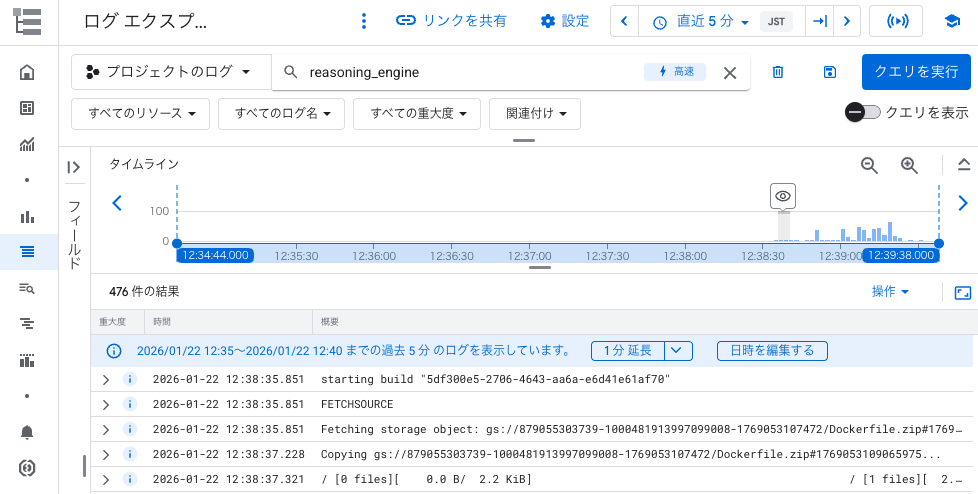

In [17]:
agent_engines = vertexai.Client().agent_engines
display_name = 'Search Agent App'

requirements = [
    'google-adk==1.21.0',
    'google-genai==1.56.0',
    'google-cloud-aiplatform==1.132.0',
]

config={
    'agent_framework': 'google-adk',
    'requirements': requirements,
    'staging_bucket': f'gs://{PROJECT_ID}',
    'display_name': display_name,
}

remote_adk_app = None
for item in agent_engines.list():
    if item.api_resource.display_name == display_name:
        remote_adk_app = agent_engines.get(name=item.api_resource.name)
        break

if not remote_adk_app:
    # Deploy a new agent.
    remote_adk_app = agent_engines.create(
        agent=search_agent_app,
        config=config,
    )
else:
    # Update the existing agent.
    remote_adk_app = agent_engines.update(
        name=remote_app.api_resource.name,
        agent=search_agent_app,
        config=config,
    )

The following requirements are missing: {'cloudpickle', 'pydantic'}


In [18]:
chat_client = ChatClient(remote_adk_app)

query = '''
今年のゴールデンウィークは、何連休でしょうか？
'''
response = await chat_client.async_stream_query(query)
display(Markdown(response))

2026年のゴールデンウィークは、**5連休**となります。具体的には、5月2日（土）から5月6日（水）までです。

また、4月29日（水）の「昭和の日」と、5月2日からの連休の間の平日である4月30日（木）と5月1日（金）に休暇を取得すると、最大で**8連休**にすることも可能です。さらに休暇を追加することで、最大12連休も可能とされています。

In [19]:
query = '''
来年はどうなりますか？
'''
response = await chat_client.async_stream_query(query)
display(Markdown(response))

2027年（令和9年）のゴールデンウィークは、**5連休**となります。具体的には、2027年5月1日（土）から5月5日（水）までです。

4月29日（木）の昭和の日は単独の祝日となりますが、4月30日（金）の平日と5月6日（木）、7日（金）の平日を休みにすると、最長で**11連休**にすることも可能です（4月29日（木）から5月9日（日）まで）。

ローカルで実行した場合と同様にセッション情報が参照できます。（ただし、Session オブジェクトではなく、Python dict の形式で返ってきます。）

In [20]:
user_id = chat_client.user_id
session_id = chat_client.session_id

user_id, session_id

('default_user', '457607668509442048')

In [21]:
session = await chat_client.adk_app.async_get_session(
    user_id = user_id,
    session_id = session_id,
)

session

{'state': {},
 'lastUpdateTime': 1769057521.738699,
 'userId': 'default_user',
 'appName': 'search_agent_app',
 'events': [{'turnComplete': None,
   'content': {'role': 'user',
    'parts': [{'videoMetadata': None,
      'mediaResolution': None,
      'codeExecutionResult': None,
      'functionCall': None,
      'thoughtSignature': None,
      'inlineData': None,
      'executableCode': None,
      'fileData': None,
      'text': '\n今年のゴールデンウィークは、何連休でしょうか？\n',
      'functionResponse': None,
      'thought': None}]},
   'usageMetadata': None,
   'branch': None,
   'errorCode': None,
   'outputTranscription': None,
   'invocationId': 'e-2a1d2d41-1d83-4b36-8b57-349c19291245',
   'modelVersion': None,
   'interactionId': None,
   'timestamp': 1769057514.889019,
   'interrupted': None,
   'id': '41764708662902784',
   'logprobsResult': None,
   'liveSessionResumptionUpdate': None,
   'finishReason': None,
   'customMetadata': None,
   'groundingMetadata': None,
   'partial': None,
   'inp

In [22]:
for event in session['events']:
    print(format_timestamp(event['timestamp']), event['author'])

2026-01-22 04:51:54.889019 user
2026-01-22 04:51:55.013123 search_agent
2026-01-22 04:51:58.147346 user
2026-01-22 04:51:58.255183 search_agent


In [23]:
search_queries = session['events'][1]['groundingMetadata']['webSearchQueries']
entry_point_html = session['events'][1]['groundingMetadata']['searchEntryPoint']['renderedContent']

print(search_queries)
display(HTML(entry_point_html))

['2026年 ゴールデンウィーク 何連休', '2026年 ゴールデンウィーク 期間']


## 後片付け

デプロイしたエージェントを削除します。

※ デプロイ済みエージェントの管理は、Cloud Console の [Agent Engines](https://console.cloud.google.com/vertex-ai/agents/agent-engines) のページから行います。

In [24]:
remote_adk_app.delete(force=True)